<a href="https://colab.research.google.com/github/bokutachi256/gisday2021/blob/main/%5BGISDAY2021%5D_5_%E5%AE%8C%E6%88%90%E7%89%88%E3%81%AE%E9%81%BF%E9%9B%A3%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mesaのインストール

In [ ]:
!pip install mesa

     |████████████████████████████████| 668 kB 7.7 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


# ライブラリの読み込む及びエージェントと関数の定義

In [ ]:
%matplotlib notebook

import numpy as np
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# スペースの定義
class EvacModel(Model):

  # コンストラクタにwall（壁の位置を示すndarray）を追加した
  def __init__(self, N, width, height, start_x, start_y, goal_x, goal_y, wall):
    # 避難者エージェントの数をNに設定する
    self.num_agents = N
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus=False)

    # 壁の座標を保持するプロパティの定義
    self.wall_x = list()
    self.wall_y = list()
    
    # 壁の定義をプロパティとして保持する
    self.wall = wall
    # ゴール地点の座標を設定する（goal_xとgoal_y)
    self.goal = (goal_x, goal_y)
    # 避難完了者をカウントする（0で初期化）
    self.evac_comp = 0
    # EvacAgentの実行順序をランダムに設定する
    self.schedule = RandomActivation(self)

    # 避難者エージェントの作成．num_agentsの数だけエージェントを作成する
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      self.schedule.add(a)
      # エージェントを配置する
      self.grid.place_agent(a, (start_x, start_y))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters={"Goal": compute_goal, "evacuator": goal_pop},
        agent_reporters={"Pos": "pos", "Goal": "mygoal", "Strategy": "strategy"})

    # 避難者エージェント配置直後（初期状態）の状況をデータコレクターで取得  
    self.datacollector.collect(self)
  
    # 壁エージェントを配置する
    # 壁の配列から座標を取得する．壁の配列は上下反転させる
    wall_y = np.where(np.flipud(self.wall) >0)[0]
    wall_x = np.where(np.flipud(self.wall) >0)[1]
    # 取得した壁の座標に壁エージェントを配置する
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (wall_x[i], wall_y[i]))
      # 壁の座標を保持する
      self.wall_x.append(wall_x[i])
      self.wall_y.append(wall_y[i])
    
    # ゴールエージェントの配置
    a = GoalAgent(1, self)
    self.grid.place_agent(a, (goal_x, goal_y))

  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)

# そのステップでゴールした人数を求める関数
def goal_pop(model):
  return(model.evac_comp)

# ゴールした人数の累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)

# 二つのエージェントの距離を求める関数
def calc_dist(loc1, loc2):
  return np.sqrt(np.sum(np.square(np.array(loc1)-np.array(loc2))))
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0
    self.category = 'evacagent'
    self.strategy = random.randrange(1, 5)
 
  # エージェントの移動
  def move(self):

    # 自分の周囲のセル（4方向）にあるセルを検索する．
    possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    # その中で移動可能（エージェントがいない（エージェントの数が1未満））なセルを検索する
    possible_steps2 = [a for a in possible_steps if len(self.model.grid.get_cell_list_contents(a)) < 1]
    # 周囲4方向のセルにゴールが含まれている場合は移動可能なセルにゴールのセルを加える．
    possible_steps2.extend([a.pos for a in self.model.grid.get_neighbors(self.pos, moore=False, include_center=False) if a.category=='goal'])
    possible_steps3 = []

    # 自分を中心とする検索範囲（プラスマイナス2メッシュ内）のエージェントを検索する
    neighbor_agents = self.model.grid.get_neighbors(self.pos, moore=True, radius=self.strategy, include_center=False)
    # 検索範囲にゴールがあるかどうか判定する
    if 'goal' in [a.category for a in neighbor_agents]: # ゴールがあった場合
      # ゴールの座標を取得する
      goalpos = [a.pos for a in neighbor_agents if a.category=='goal']
      # 自分とゴールの距離を求める 
      self_goal_dis = calc_dist(goalpos, self.pos)
      # エージェントがいないセルからゴールまでの距離を求める
      distances = [calc_dist(goalpos, a) for a in possible_steps2]
      # 自分の現在位置よりゴールに近くなる移動候補のみを取り出す
      possible_steps3 = [a for a, b in zip(possible_steps2, distances) if b < self_goal_dis]

    if len(possible_steps3) > 0: # ゴールに近づくセルに移動
      new_position = self.random.choice(possible_steps3)
    elif len(possible_steps2) > 0: # エージェントのいないセルに移動
      new_position = self.random.choice(possible_steps2)      
    else: # 動ける場所がない場合は移動しない
      new_position = self.pos

    self.model.grid.move_agent(self, new_position)
  
  # ゴールに到達したか判定する関数
  def if_goal(self):
    if self.pos == self.model.goal:
      self.mygoal += 1
      self.model.evac_comp += 1
      # ゴールしたらエージェントを削除する
      self.model.grid.remove_agent(self)

  def step(self):
    if self.mygoal == 0:
      self.move()
      self.if_goal()

# ゴールエージェントの定義
class GoalAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    # エージェントの種類を示すプロパティを追加
    self.category = 'goal'

# 壁エージェントの定義
class WallAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.category = 'wall'


# モデルの実行

In [ ]:
# モデルを実行する
start_x = 9
start_y = 9
goal_x = 0
goal_y = 0

# 壁の定義（1: 壁，0: 通路）

wall0 = np.array(
    [[0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0]])

wall1 = np.array(
    [[0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,1,0,0,1,0,1,0,0,0],
     [0,1,0,0,1,0,1,1,0,0],
     [0,1,0,0,1,0,1,0,0,0],
     [0,1,0,0,1,0,1,0,0,1],
     [0,1,0,0,1,0,1,0,0,0],
     [0,1,0,0,1,0,1,1,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0]])

wall2 = np.array(
    [[0,0,0,0,0,0,0,0,0,0],
     [0,0,0,1,0,0,0,0,1,0],
     [0,1,1,1,0,0,0,1,1,0],
     [0,0,0,0,0,1,0,0,1,0],
     [0,1,1,0,0,1,0,0,1,0],
     [0,0,1,0,0,1,1,1,1,0],
     [0,0,1,1,0,0,0,0,0,0],
     [0,0,0,1,1,1,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,1,0,0,0,1,1,1,0]])


wall3 = np.array(
    [[0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0],
     [0,0,0,0,1,0,0,0,0,0]])

wall = wall0

# モデルの生成，引数として壁の定義を加える
model = EvacModel(20, 10, 10, start_x, start_y, goal_x, goal_y, wall)

# 全員が避難するまで実行する
while min([agent.mygoal for agent in model.schedule.agents]) < 1:
  model.step()


# アニメーションの生成

In [ ]:
# 計算結果のアニメーションを作成する
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ゴールをプロット
plt.text(goal_x, goal_y, 'Goal', size=14, ha='center')
plt.scatter(goal_x, goal_y, s=800, marker="s")

# imshowを使って壁配列を描画する．原点の移動と配列の上下反転を行う．
plt.imshow(np.flipud(wall), origin='lower')

# 壁をプロット
plt.scatter(model.wall_x, model.wall_y, c='gray', s=200, marker="s")

ims = []
step = 3

# 0 Stepめのエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

for i in tqdm(range(1, 500)):
  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  strategy = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Strategy'].map(lambda x: (0, 0) if x is None else x)
  for u in range(step):
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s=1000, c=strategy, cmap=cm.seismic, marker="*")
    # グラフをリストに加える
    ims.append([im])
  x0 = x
  y0 = y

ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim

# ゴール過程のグラフ化

<function matplotlib.pyplot.show>

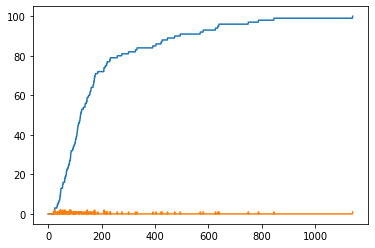

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show